# Implement Diffusion Model (small one)

## Import framework

In [2]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

device = torch.device('cuda')

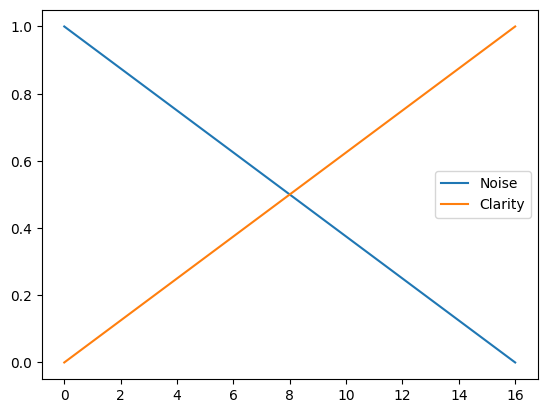

In [4]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

## Import data

In [5]:
# Prepare CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


## 1_
Look at the data. What is `all_trainset`? Diplay one element of `all_trainset`. Try to print a image 

*Hint: use .permute()*.

In [6]:
all_trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

When we look at the first example of our dataset, we have a couple *a tuple* $(x,y)$. $x$ is the image as a tensor, and $y$ a integer that is the label of the class. See [CIFAR10 website](https://www.cs.toronto.edu/~kriz/cifar.html).

In [7]:
all_trainset[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

Each image is a tensor with shape $(3, 32, 32)$. the size of an image is $(32,32)$ as they are in color, we have 3 channels *(red, green, blue)*.

In [8]:
all_trainset[0][0].shape

torch.Size([3, 32, 32])

A way to plot an image. We used `permute` in order to obtain tensor (then narray) with shape $(32,32,3)$.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


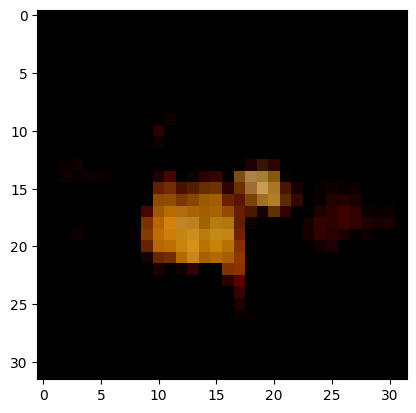

In [9]:
plt.imshow(all_trainset[3][0].permute(1, 2, 0).numpy().astype(np.float32))

## 2_
- Create a list `idx` of idexes of elements of `all_trainset` where the label is a car.
- Then create `sub_trainset` with the class `Subset` from `torch.utils.data`.

In [10]:
# filter training imgs
idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

The dataset is equally distributed among the 10 classes. That is why we have $50000/10=5000$ examples labeled "car".

In [11]:
len(sub_trainset)

5000

In [12]:
sub_trainset[0][0]

tensor([[[ 0.3333,  0.3176,  0.3882,  ...,  0.2706,  0.2392,  0.2314],
         [ 0.3176,  0.3490,  0.3412,  ...,  0.2471,  0.2235,  0.2078],
         [ 0.2078,  0.1686,  0.0118,  ...,  0.2627,  0.2314,  0.2078],
         ...,
         [-0.4196, -0.4039, -0.3882,  ..., -0.4431, -0.4667, -0.5216],
         [-0.4667, -0.4588, -0.4353,  ..., -0.4039, -0.4431, -0.4431],
         [-0.4745, -0.4667, -0.4588,  ..., -0.4118, -0.4431, -0.4275]],

        [[ 0.4118,  0.3961,  0.4510,  ...,  0.4039,  0.3961,  0.3882],
         [ 0.4196,  0.4510,  0.4353,  ...,  0.3882,  0.3804,  0.3647],
         [ 0.3333,  0.2941,  0.1294,  ...,  0.3961,  0.3882,  0.3647],
         ...,
         [-0.3412, -0.3333, -0.3333,  ..., -0.4118, -0.4353, -0.4902],
         [-0.4039, -0.3961, -0.3804,  ..., -0.3725, -0.4118, -0.4118],
         [-0.4118, -0.4039, -0.4118,  ..., -0.3804, -0.4118, -0.3961]],

        [[ 0.5529,  0.5373,  0.5922,  ...,  0.6863,  0.6784,  0.6627],
         [ 0.5529,  0.5765,  0.5686,  ...,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


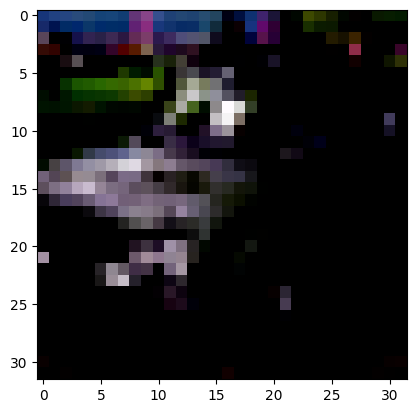

In [13]:
plt.imshow(sub_trainset[3][0].permute(1, 2, 0).numpy().astype(np.float32))

In [14]:
trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

The `cvtImg` function normalize an image.
The `show_examples` function plot the first 25 images.
Note that with `next(iter(trainloader))` we obtain a tuple of lists: `x` contains the images and `_` the labels (useless since they are the same).

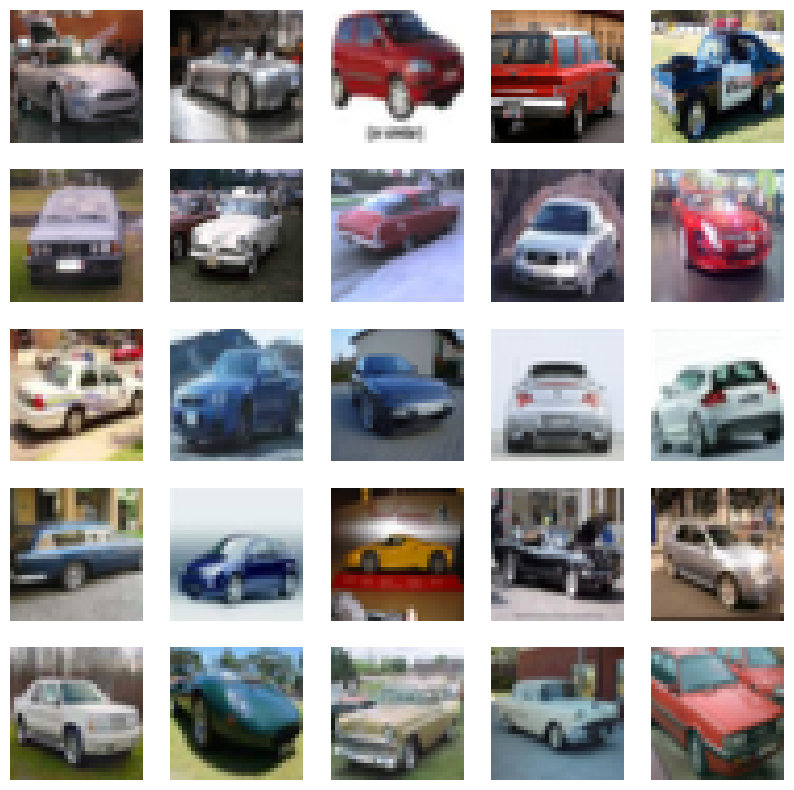

In [15]:
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

## 3_
Creation of functions.

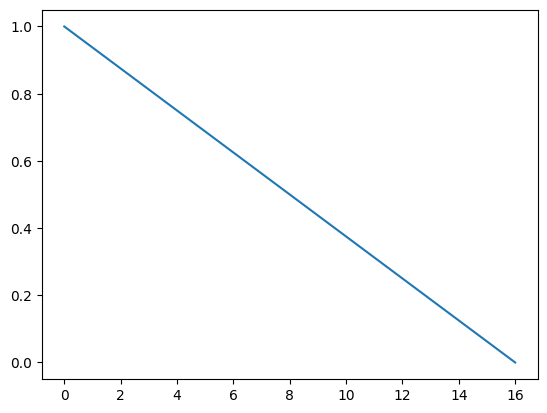

In [16]:
plt.plot(time_bar)

In [17]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)



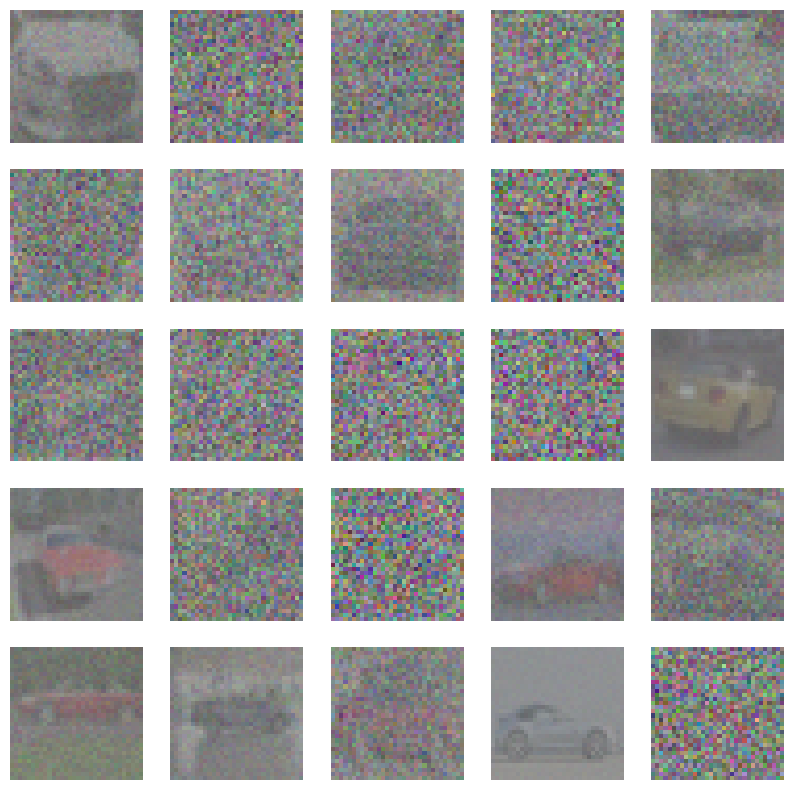

In [18]:
# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

## 12/03 workshop

The goal is to understand some layers used in Neural Network. 
- What is a linear layer, conolutionalv layer? 
- What is normalization? 
- What is a forward function?

We are going to use `torch.nn` and `torch.nn.functional`.

# 4_
Build the class `Block` following this architecture.

## Constructor `__init__`
### 4_1 Convolution
Look at the [the code documentation nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to understand how does the class work.
- What does `in_channels`, `out_channels`, `kernel_size` and `padding` mean?

|Attributes Name  | Type    | in_channels |  out_channels |  kernel_size |  padding|
|-----------------|---------|-------------|---------------|--------------|---------|
|`self.conv_param`|`Conv2d` |`in_channels`|   128         | 3            |   1     |
|`self.conv_out`  |`Conv2d` |`in_channels`|   128         | 3            |   1     |


### 4_2 Linear
Look at the the code documentation.
- What is a Linear layer ? 

|Attributes Name  | Type    | in_features |  out_features | 
|-----------------|---------|-------------|---------------|
|`self.dense_ts`  |`Linear` | 192         |   128         |

### 4_3 Normalization
Look at the the code documentation.
- What is a Layer Normalization ? 

|Attributes Name  | Type    | normalized_shape | 
|-----------------|---------|------------------|
|`self.layer_norm`|`LayerNorm`|`[128, size, size]`|

In [74]:
import torch.nn.functional as F

In [130]:
class Block(nn.Module):
    """The class Block is a subclass of nn.Module, from PyTorch, 
    which is the base class for all neural network modules.
    """
    def __init__(self, in_channels=128, size=32):
        """The constructor of the class. We will define attributes that describe the Neural Network Block.

        Args:
            in_channels (int, optional): Number in input. Defaults to 128.
            size (int, optional): Size of the square image. Defaults to 32.
        """
        super(Block, self).__init__()
        
        # write here the attributes described above (task 4_)

        # Convolution
        self.conv_param = nn.Conv2d(in_channels, 128, 3, 1, 1)
        self.conv_out = nn.Conv2d(in_channels, 128, 3, 1, 1)

        # Linear
        self.dense_ts = nn.Linear(192, 128)

        # Normalization
        self.layer_norm = nn.LayerNorm([128, size, size])





    def forward(self, x_img, x_ts):
        """Forward function of Block. 

        Args:
            x_img (torch.float32): Images in input. Shape=()
            x_ts (_type_): _description_

        Returns:
            _type_: _description_
        """
        
        x_out = self.conv_out(x_img)
        x_parameter = self.conv_param(x_img)
        x_parameter = F.relu(x_parameter)
        time_parameter = self.dense_ts(x_ts)
        time_parameter = F.relu(time_parameter)

        x_parameter *= time_parameter.view(-1, 128, 1, 1)
        x_out += x_parameter
        x_out = F.relu(x_out)

        # Hint: before multiplying x_parameter * time_parameter, 
        # make sure to have the same dimension. Use  time_parameter.view(...)

        
        return x_out

# 5_ Forward function of `Block`
Architecture of forward function:


![](task_5.png)
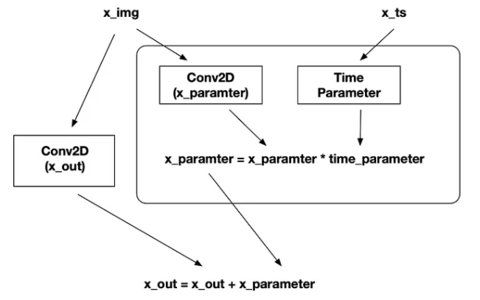


In this sketch, a variable in parenthesis is the name of the output.

### 5_1 Code output
Here are some code output, once the class `Block` is done. 

In [131]:
block = Block(in_channels=3)

In [132]:
print(block)

Block(
  (conv_param): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense_ts): Linear(in_features=192, out_features=128, bias=True)
  (layer_norm): LayerNorm((128, 32, 32), eps=1e-05, elementwise_affine=True)
)


In [133]:
x[0].shape

torch.Size([3, 32, 32])

In [134]:
out = block.forward(x_img=torch.randn(32, 3, 32, 32),
                    x_ts=torch.full([1, 192], 2, dtype=torch.float))

In [135]:
out.shape

torch.Size([32, 128, 32, 32])

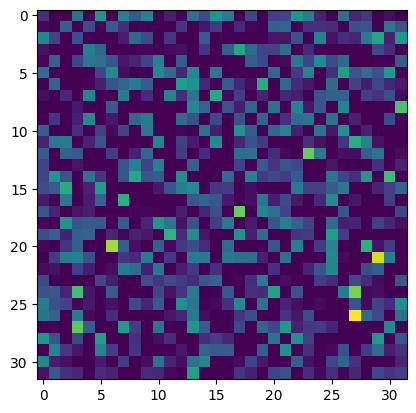

In [140]:
plt.imshow(out[0][0].detach().numpy())

# 6_
We are now going to create our Model, as a class named `Model`, a subclass of `nn.Module`.


In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # next time







    def forward(self, x, x_ts):
        # next time









        return x

model = Model().to(device)